In [ ]:
import pandas as pd
import math
import seaborn as sns
import numpy as np

In [ ]:
movements = pd.read_csv("../data/data_movements_10.csv")
records = pd.read_csv("../data/data_trials_10.csv")

In [ ]:
sns.scatterplot(data = movements.loc[movements.state == 'reach'], x = 'x', y = 'y', hue = 'trial')

In [ ]:
movements

In [ ]:
dist = lambda x1, y1, x2, y2: math.sqrt((y2 - y1)**2 + (x2 - x1)**2)

dx = [0]
dt = [0]
for i in range(1, len(movements)):
    prev_row = movements.iloc[i - 1]
    cur_row = movements.iloc[i]
    dx.append(dist(prev_row.x, prev_row.y, cur_row.x, cur_row.y))
    dt.append(cur_row.time - prev_row.time)

movements['dx'] = dx
movements['dt'] = dt

In [ ]:
movements['vel'] = movements.dx / movements.dt

In [ ]:
reach = movements.loc[movements.state == 'reach']
max_vel = reach[['trial', 'dx', 'dt', 'vel']].groupby('trial').agg({'vel': 'max'}).reset_index().rename(columns={'vel': 'max_vel'})

joined = pd.merge(reach, max_vel, on='trial', how='left')
mx_points = joined.loc[joined.vel == joined.max_vel]
first_points = reach.groupby('trial').agg(lambda x: list(x)[0]).reset_index()

In [ ]:
mx_points

In [ ]:
first_points

In [ ]:
sns.lineplot(data = movements.loc[movements.state == 'reach'], x = 'x', y = 'y', hue = 'trial', sort = False)

In [ ]:
movements = pd.read_csv('../data/data_movements_7.csv')
trials = pd.read_csv('../data/data_trials_7.csv')
trials['trial'] = trials.trial - 1

In [ ]:
uncertainty_cols = ['no_uncertainty', 'low_uncertainty', 'high_uncertainty', 'unlimited_uncertainty']
def uncertainty_label(x):
    if all(x[col] == 0 for col in uncertainty_cols):
        return 'w/b'
    for col in uncertainty_cols:
        if x[col] == 1:
            return col

trials['uncertainty'] = trials.apply(uncertainty_label, axis=1)

In [ ]:
joined = pd.merge(movements, trials[['trial', 'uncertainty']], on='trial', how='left')

rand_trials = np.random.choice([i for i in range(110, 180)], 20)

# smpl = joined.loc[(joined.state == 'reach') & (joined.trial.isin(rand_trials))]

smpl = joined.loc[(joined.state == 'reach') & (joined.trial.isin(rand_trials) & (joined.uncertainty.isin(['low_uncertainty', 'high_uncertainty', 'no_uncertainty'])))]

sns.lineplot(data = smpl.loc[smpl.state == 'reach'], x = 'x', y = 'y', hue = 'uncertainty', sort = False)


Checking for correct recording of movements post changes to exp. run code

In [ ]:
test = pd.read_csv('../data/data_movements_demo.csv')
test.loc[test.trial ==6]

In [4]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy.contrasts import Diff
import patsy
import scipy.stats as stats
import pandas as pd 
import numpy as np
import pingouin as pg

d = pd.read_csv("../data/regression_data.csv")
d.trial = d.trial + 1
def fit_reg_ff_1(d):
        
        mod_formula = "np.log(initial_theta) ~ "
        mod_formula += "C(previous_uncertainty, Diff) * midpoint_error + "
        mod_formula += "trial + "
        mod_formula += "1"

        # NOTE: statsmodels
        mod = smf.ols(mod_formula, data=d)
        res_sm = mod.fit()

        # NOTE: pingouin
        y, X = patsy.dmatrices(mod_formula, d, return_type='dataframe')
        res_pg = pg.linear_regression(X, np.squeeze(y.to_numpy()), relimp=True)

        return res_sm, res_pg

fit_reg_ff_1(d)

(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x28f19d970>,
                                                names      coef        se  \
 0                                          Intercept  1.145604  0.065588   
 1  C(previous_uncertainty, Diff)[D.high_uncertainty]  0.051687  0.235624   
 2   C(previous_uncertainty, Diff)[D.low_uncertainty] -0.068522  0.159372   
 3    C(previous_uncertainty, Diff)[D.no_uncertainty]  0.346320  0.123895   
 4                                     midpoint_error  0.116054  0.010968   
 5  C(previous_uncertainty, Diff)[D.high_uncertain... -0.014666  0.039802   
 6  C(previous_uncertainty, Diff)[D.low_uncertaint...  0.013657  0.026934   
 7  C(previous_uncertainty, Diff)[D.no_uncertainty... -0.060829  0.022452   
 8                                              trial -0.000548  0.000231   
 
            T          pval        r2    adj_r2  CI[2.5%]  CI[97.5%]    relimp  \
 0  17.466616  3.184174e-47  0.471841  0.457321  1.016516   1.2746

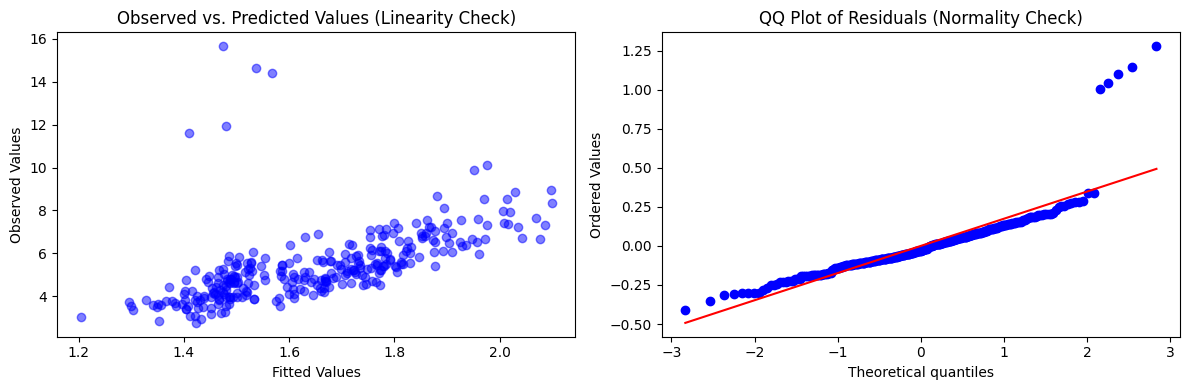

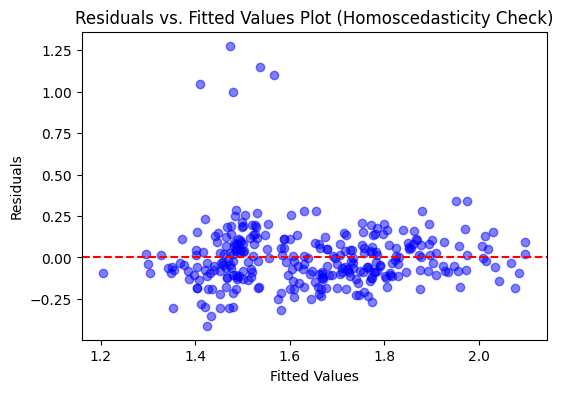

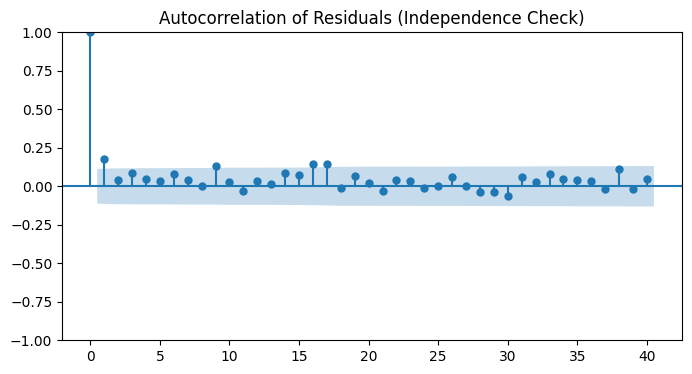

                                            Variable        VIF
0                                          Intercept  32.086186
1  C(previous_uncertainty, Diff)[D.high_uncertainty]  52.797666
2   C(previous_uncertainty, Diff)[D.low_uncertainty]  39.784283
3    C(previous_uncertainty, Diff)[D.no_uncertainty]  28.577283
4                                     midpoint_error   2.472223
5  C(previous_uncertainty, Diff)[D.high_uncertain...  47.977145
6  C(previous_uncertainty, Diff)[D.low_uncertaint...  32.077132
7  C(previous_uncertainty, Diff)[D.no_uncertainty...  19.322508
8                                              trial   2.993170


In [2]:

import statsmodels.stats.outliers_influence as oi

res_sm, res_pg = fit_reg_ff_1(d)

# Assumption tests
# 1. Linearity Check (Observed vs. Predicted)
fitted_values = res_sm.fittedvalues
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(fitted_values, d['initial_theta'], color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Observed Values')
plt.title('Observed vs. Predicted Values (Linearity Check)')

# 2. Normality of Residuals (QQ Plot)
residuals = res_sm.resid
plt.subplot(1, 2, 2)
stats.probplot(residuals, plot=plt)
plt.title('QQ Plot of Residuals (Normality Check)')

plt.tight_layout()
plt.show()

# 3. Homoscedasticity Check (Residuals vs. Fitted Values)
plt.figure(figsize=(6, 4))
plt.scatter(fitted_values, residuals, color='blue', alpha=0.5)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted Values Plot (Homoscedasticity Check)')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

# 4. Independence of Residuals (Autocorrelation Plot)
fig, ax = plt.subplots(figsize=(8, 4))
sm.graphics.tsa.plot_acf(residuals, ax=ax, lags=40)
plt.title('Autocorrelation of Residuals (Independence Check)')
plt.show()

# 5. Multicollinearity Check (VIF)
X = res_sm.model.exog
vif = pd.DataFrame()
vif["Variable"] = res_sm.model.exog_names
vif["VIF"] = [oi.variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif)

# Additional statistical tests can be performed as needed.
